Compute the CPT for the FEV1, Unblocked FEV1, % Airway Blockage factor function

We'll apply what we've learned in uniform_x_uniform.ipynb to compute the CPT for the factor function which is the joint probability density function $f_{FEV_1}(Unblocked\ FEV1, \%Small\ Airway\ Blockage)$ 

In [1]:
import pandas as pd
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import src.models.helpers as mh

# Visualise sampling/closed form solutions

## Using FEV1 = HFEV1 * Airway availability

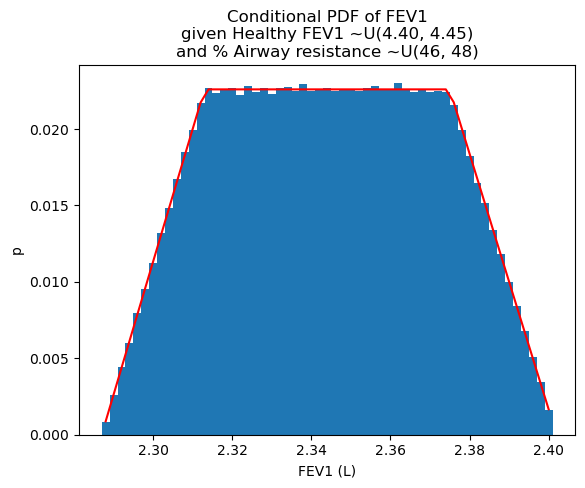

In [4]:
u1 = 4.4
u2 = 4.45
b1 = 0.52
b2 = 0.54
s1 = 1 - b2
s2 = 1 - b1
# s1 = 0.4
# s2 = 0.6
# b2 = 1 - s1
# b1 = 1 - s2

fev1_bins = np.arange(u1 * b1, u2 * b2, 0.002)


# Sampling solution: generate a set of unblocked FEV1 and % Small Airway blockage and their corresponding FEV1 values
fev1_samples = mh.generate_fev1_sample(u1, u2, s1, s2, n=1000000)["FEV1"]
# Histogram up the sample values into fev1_bins
hist, bins = np.histogram(fev1_samples, bins=fev1_bins)
# Normalize the histogram
hist_norm = hist / len(fev1_samples)


# Closed form solution
fev1_hist = []
for i in range(0, len(fev1_bins) - 1):
    fev1_low = fev1_bins[i]
    fev1_up = fev1_bins[i + 1]

    val, abserr = integrate.quad(mh.PDF_X_x_Y, fev1_low, fev1_up, args=(b1, b2, u1, u2))
    fev1_hist.append(val)


# Plot the histogram
plt.plot(fev1_bins[:-1], fev1_hist, "r")
plt.bar(bins[:-1], hist_norm, width=0.002)
# Set y label to Probability Density Function, set x label to FEV1 (L)
plt.title(
    f"Conditional PDF of FEV1\ngiven Healthy FEV1 ~U({u1:.2f}, {u2:.2f})\nand % Airway resistance ~U({int(s1*100)}, {int(s2*100)})"
)
plt.ylabel("p")
plt.xlabel("FEV1 (L)")
plt.show()

## Using FEV1 = HFEV1 * (1 - AirwayBlockage)

Sum of probabilities: 0.9999540194649588


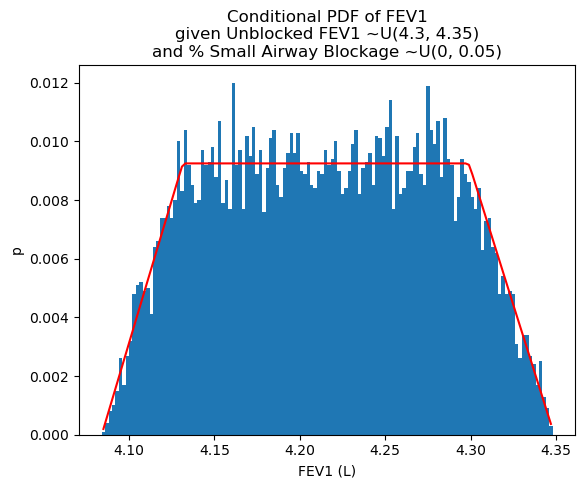

In [22]:
u1 = 4.3
u2 = 4.35
b1 = 0
b2 = 0.05

fev1_bins = np.arange(u1 * (1 - b2), u2 * (1 - b1), 0.002)

# Sampling solution: generate a set of unblocked FEV1 and % Small Airway blockage and their corresponding FEV1 values
fev1_samples = mh.generate_fev1_sample(u1, u2, b1, b2)["FEV1"]
# Histogram up the sample values into fev1_bins
hist, bins = np.histogram(fev1_samples, bins=fev1_bins)
# Normalize the histogram
hist_norm = hist / len(fev1_samples)

# Closed form solution
fev1_hist = []
for i in range(0, len(fev1_bins) - 1):
    fev1_low = fev1_bins[i]
    fev1_up = fev1_bins[i + 1]

    val, abserr = integrate.quad(
        mh.PDF_X_x_1_minus_Y, fev1_low, fev1_up, args=(u1, u2, b1, b2)
    )
    fev1_hist.append(val)

print(f"Sum of probabilities: {sum(fev1_hist)}")

# Plot the histogram
plt.plot(fev1_bins[:-1], fev1_hist, "r")
plt.bar(bins[:-1], hist_norm, width=0.002)
# Set y label to Probability Density Function, set x label to FEV1 (L)
plt.title(
    "Conditional PDF of FEV1\ngiven Unblocked FEV1 ~U({}, {})\nand % Small Airway Blockage ~U({}, {})".format(
        u1, u2, b1, b2
    )
)
plt.ylabel("p")
plt.xlabel("FEV1 (L)")
plt.show()

### Compute CPT from sampling

Since we don't know how to do inference on continuous probability distributions, we need discretize the above model and compute the CPT.

Here's how to discretise the model by sampling
1. Define bins for each variable
2. Add up the bin to which the variable corresponds to
3. Group by the same set of inputs, and outputs and count the number of occurences of each groups
4. Normalize by the total amount of occurences. 

The CPT has three dimensions. For each possible set of bins, it will associate a probability.

Knowing that $P(x \in FEV_1\ bin) = \frac{\#FEV_1\ bin\ outcomes}{\#outcomes}$, we can agglomerate the sample values into bins (i.e. histogram up) and use the bin counts to estimate the CPT of FEV1, Unblocked FEV1, and % Small Airway blockage

In [ ]:
# df_binned_sampled = mh.generate_fev1_sample(10000)

# # We must use range, and then convert to floats, otherwise we end up with 0.1, 0.2, 0.30000000000000004, etc.
# # 2.0-2.2, 2.2-2.4, 2.4-2.6, etc.
# bins_unblocked_fev1 = [x / 10 for x in range(20, 60 + 1, 20)]
# # 0-10%, 10-20%, 20-30%, etc.
# bins_small_airway_blockage = [x / 10 for x in range(0, 10 + 1, 2)]
# # 0.0-0.2, 0.2-0.4, 0.4-0.6, etc.
# bins_fev1 = [x / 10 for x in range(0, 60 + 1, 20)]

# df_binned_sampled["Unblocked FEV1 bin"] = df_binned_sampled["Unblocked FEV1"].apply(
#     lambda x: get_bin_for_value(x, bins_unblocked_fev1)
# )
# df_binned_sampled["Small airway blockage bin"] = df_binned_sampled[
#     "Small airway blockage"
# ].apply(lambda x: get_bin_for_value(x, bins_small_airway_blockage))
# df_binned_sampled["FEV1 bin"] = df_binned_sampled["FEV1"].apply(
#     lambda x: get_bin_for_value(x, bins_fev1)
# )

In [ ]:
# df_cpt = (
#     df_binned_sampled.groupby(
#         ["Unblocked FEV1 bin", "Small airway blockage bin", "FEV1 bin"]
#     )
#     .size()
#     .reset_index(name="count")
# )
# df_cpt["p"] = df_cpt.apply(lambda x: x["count"] / len(df_binned_sampled), axis=1)


Main issues: creating the CPTs by sampling 
* Takes an gigantic amount of time: 40s to generate
* Is inaccurate. Under the previous settings, the sets of unique inputs/outpus has 9k elements


### Compute the CPT from closed form
* variable node message: column vector
* factor node message: column vector
* CPT: matrix (childs, parents)

In Pandas' dot product `df.dot(other) or df @ other`, other can be a dataframe, a series, an np.array.

Pandas vs NumPy: Pandas is more user-friendly, but NumPy is faster. Pandas has a lot more options for handling missing data, but NumPy has better performance on large datasets.

Flow to create the CPT(childs, parents)
1. Create a list of bins for the child variables, and for the parent variables
2. Using the dimensions for this list, generate the CPT matrix
3. Fill the matrix with the values from the closed form solution

In [3]:
# Define the variables
unblocked_fev1 = mh.VariableNode("Unblocked FEV1", 2, 6, 0.2)
small_airway_blockage = mh.VariableNode("Small airway blockage", 0, 1, 0.1)
fev1 = mh.VariableNode("FEV1", 0, 6, 0.2)

# mh.calc_cpt(unblocked_fev1, small_airway_blockage, fev1)

#### Validate CPT from closed form

In [4]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation

In [5]:
U = mh.VariableNode("Unblocked FEV1", 2, 6, 0.1)
C = mh.VariableNode("Small airway clearance", 0.1, 1, 0.1)
FEV1 = mh.VariableNode("FEV1", 0.2, 6, 0.1)

In [6]:
# Validate the CPT with 2 examples

cpt = mh.calc_cpt(U, C, FEV1)
cpt2d = mh.calc_pgmpy_cpt_X_x_1_minus_Y(U, C, FEV1)

calculating cpt of shape 58 x 40 x 9 (C x A x B) 


AssertionError: Error calculating cpt: The sum of the probabilities should be 1
 Distributions: U(0.1, 0.2), B(2.0, 2.1)
 P(C|U,B) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 With C range (0.2, 0.42000000000000004)
 For the C bins: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5
 5.6 5.7 5.8 5.9 6. ]
 Abserr = 0.0

U: 2-2.1

C: 0.1-0.2

F: 0.2-0.42; intersects 0.2-0.3, 0.3-0.4, 0.4-0.5 with the two first bins almost equiprobable and the last one with a low p => correct!

U: 4.5-4.6 => idx 25 (2-2.1 = 0, 2.1-2.2 = 1)

C: 0.7-0.8 => idx 6 (0.1-0.2 = 0, 0.2-0.3 = 1)

F: 3.15-3.68; intersects 3.1-3.2 (half), 3.2-3.3 ... 3.5-3.6, 3.6-3.7 (80% of this interval).

0.2-0.3 = 0, 0.3-0.4 = 1 => do -2

F: 0.2-6 => the cpt is non null for 6 bins, from idx 29 to 29+5=34

### Validate queries work fine


In [10]:
# Build graph
graph = BayesianNetwork([(U.name, FEV1.name), (C.name, FEV1.name)])

cpt_fev1 = TabularCPD(
    variable=FEV1.name,
    variable_card=len(FEV1.midbins),
    values=cpt2d.tolist(),
    evidence=[C.name, U.name],
    evidence_card=[len(C.midbins), len(U.midbins)],
)

prior_c = TabularCPD(
    variable=C.name,
    variable_card=len(C.midbins),
    values=C.marginal(C),
    evidence=[],
    evidence_card=[],
)

prior_u = TabularCPD(
    variable=U.name,
    variable_card=len(U.midbins),
    values=U.marginal(U),
    evidence=[],
    evidence_card=[],
)

graph.add_cpds(cpt_fev1, prior_c, prior_u)

graph.check_model()

True

We observe FEV1 in idx = 0, i.e. in the 0.2-0.3 L bin

We want to infer back Unblocked FEV1 and Small Airway Clearance

What are all sets of parents C and U that give 0.2-0.3 of FEV1?

U: 2-2.1\
C: 0.1-0.2 => F: 0.2-0.42 => works\
C: 0.2-0.3 => F: 0.4-... => to high

U: 2.1-2.2\
C: 0.1-0.2 => F: 0.21-0.44 => works

...

U: 2.9-3.0\
C: 0.1-0.2 => F: 0.29-0.6 => works

U: 3.0-3.1\
C: 0.1-0.2 => F: 0.3-... => point integral => p=0

For U: P should be non zero for 2-2.9 => 10 first elements\
For C: P([0.1-0.2]) = 1, all other values of C are too high

In [11]:
bp = BeliefPropagation(graph)
res = mh.query(variables=[U.name], evidence={FEV1.name: 0})
print(f"shape of the response {res.values.shape}")
res.values

  0%|          | 0/1 [00:00<?, ?it/s]

shape of the response (40,)


array([0.21428602, 0.18281378, 0.15414052, 0.12790869, 0.10381917,
       0.08161978, 0.06109644, 0.04206622, 0.02437187, 0.0078775 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [12]:
bp = BeliefPropagation(graph)
res = mh.query(variables=[C.name], evidence={FEV1.name: 0})
print(f"shape of the response {res.values.shape}")
res.values

  0%|          | 0/1 [00:00<?, ?it/s]

shape of the response (9,)


array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

We observe FEV1 in idx = 25, i.e. in the 2.7-2.8 L bin

We want to infer back Unblocked FEV1 and Small Airway Clearance

What are all sets of parents C and U that give 0.2-0.3 of FEV1?

First bin of U with non zero probability is U: 2.7-2.8 L => index 7
C: 0.9-1 => F: 2.43-2.8 L => inside 2.7-2.8 L

U: 2.8-2.9
C: 0.9-1 => F: 2.52-2.9 L => works
C: 0.8-0.9 => outside

U: 3-3.1 => same as above

First bin of U that can provide outcomes in F for C: 0.8-0.9, U: 2.7/0.9=3 => 3-3.1
C: 0.9-1 => F: 2.7-3.1 => works
C: 0.8-0.9 => F: 2.4-2.79 => works 
C: 0.7-0.8 => outside

Last bin that has non zero probability is U: 5.9-6
C: 0.4-0.5 => F: 2.36-3 L => works

For U: P should be non zero from idx 7 and above => from element 8 to end
For C: P should be non zero starting from 0.4-0.5 up to all the rest => from element 4 (idx 3) to end 

In [13]:
bp = BeliefPropagation(graph)
res = mh.query(variables=[U.name], evidence={FEV1.name: 25})
print(f"shape of the response {res.values.shape}")
print(res.values)

fig = px.bar(y=res.values, x=U.bins)
fig.show()

  0%|          | 0/1 [00:00<?, ?it/s]

shape of the response (40,)
[0.         0.         0.         0.         0.         0.
 0.         0.02316495 0.04497655 0.04345163 0.04202672 0.04069231
 0.03944004 0.03826255 0.03715333 0.03610662 0.03511727 0.0341807
 0.03329279 0.03244984 0.03164853 0.03088584 0.03015904 0.02946567
 0.02880346 0.02817037 0.02756451 0.02698416 0.02642774 0.02589381
 0.02538103 0.02488816 0.02441408 0.02395771 0.02351809 0.02309432
 0.02268555 0.022291   0.02190994 0.02154169]


In [16]:
bp = BeliefPropagation(graph)
res = mh.query(variables=[C.name], evidence={FEV1.name: 25})
print(f"shape of the response {res.values.shape}")
res.values

fig = px.bar(y=res.values, x=C.bins)
fig.show()

  0%|          | 0/1 [00:00<?, ?it/s]

shape of the response (9,)


# Compute CPT for ecFEV1, HFEV1, AR

In [ ]:
from src.modelling_fev1.ecfev1 import calc_cpt
import src.models.var_builders as var_builders

# HFEV1, ecFEV1, AR, _, _, _, _, _, _ = var_builders.o2sat_fev1_fef2575_point_in_time_model_shared_healthy_vars_light(160, 30, "Male")
# HFEV1, ecFEV1, AR, _, _, _, _, _, _ = var_builders.o2sat_fev1_fef2575_point_in_time_model_noise_shared_healthy_vars_log(160, 30, "Male")

height=160
age=30
sex="Male"
hfev1_prior = {"type": "default", "height": height, "age": age, "sex": sex}
ho2sat_prior = {
    "type": "default",
    "height": height,
    "sex": sex,
}
HFEV1 = mh.SharedVariableNode("Healthy FEV1 (L)", 1, 7, 0.2, prior=hfev1_prior)

# Put uecFEV1 to the same max as HFEV1 (7L) otherwise P(uecFEV1 | HFEV1 = 6-6.2, AR = 0-0.01) is not possible
# Using 0-0.1L as first bin ecFEV1 and FEV1 so that the bin 0.1-0.2L doesn’t suffer from boundary approximations
uecFEV1 = mh.VariableNode("Underlying ecFEV1 (L)", 0, 7, 0.2, prior=None)
AR = mh.VariableNode("Airway resistance (%)", 0, 90, 1, prior=None)

cpt = calc_cpt(uecFEV1, HFEV1, AR)

In [13]:
import src.models.cpts.helpers as cpth

cpth.save_cpt([uecFEV1, HFEV1, AR], cpt)

# Reshape 3d cpt into 2d cpt
‘F’ means to read / write the elements using Fortran-like index order, with the first index changing fastest, and the last index changing slowest.

In [3]:
cpt.shape

(6, 225)

In [3]:
cpt2d.shape

NameError: name 'cpt2d' is not defined

In [63]:
pgmpy_cpt = np.reshape(cpt, (58, 360), order="F")

In [69]:
(pgmpy_cpt == cpt2d).all()

True